# 1. Importing Libraries & Data Files

Requirements
- matplotlib
- seaborn
- bs4
- textblob
- nltk
- sklearn
- wordcloud
- scipy
- emoji
- vaderSentiment

In [2]:
# utilities
import re
import numpy as np
import pandas as pd
import string

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# nltk and emoji
import emoji
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

# VADER and textblob for sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# model building
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KIIT\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#data viewing settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#data file paths
ind_mar_20_2020_path = "C:\Data Science\Jupyter_Workspace\Twitter_Sentiment\Archive\india_tweets_mar_27_2020.csv"

In [4]:
#loading data into python
ind_mar_20_2020_df = pd.read_csv(ind_mar_20_2020_path)

# 2. Data Visualization of Baseline Sentiments

In [5]:
ind_mar_20_2020_df.head(5)

,id,base,place,text
0,1240727929065111553,0.000000,"Jaipur, India",Insitute of Economics and Management studies: Corona virus Infection Impact ON INDIAN ECONOMY. https://t.co/mYxKb4MUKL
1,1240728214319714304,0.172222,"Bengaluru South, India",Amidst the corona scare - let’s not forget to do what we love. Let’s work on all goals we had for the days our offices would shut down. #coffeebells #corona #staysafe #selfquarantine #ipad #ipadart #sketch #painting https://t.co/ekTpWHM67r
2,1240728335795159040,-0.078125,"Bengaluru South, India","@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy"
3,1240728972335300608,0.000000,"Bhopal, India",@BDUTT What about #Favipiravir #Remdesivir #Lopinavir &amp; #Ritonavir ???\n\nhttps://t.co/Cw2Y31mOnY
4,1240729038584455170,0.283333,"Ghaziabad, India","@ultrascanhumint anchored Marco Polo is half-busy.\nIntelligent advisors with half boiled brains are crimi**lly exploiting Cameras[ since World tour is not materializing ], a Flag, in corona issue for ego promotion, a constant issue\n\nseminars, SARC videoconferencing prominently displayed 'World'"


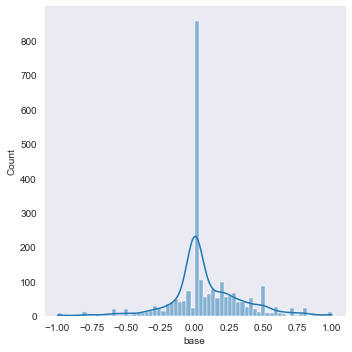

In [6]:
sns.set_style('dark')
g = sns.displot(ind_mar_20_2020_df.base,kde=True)

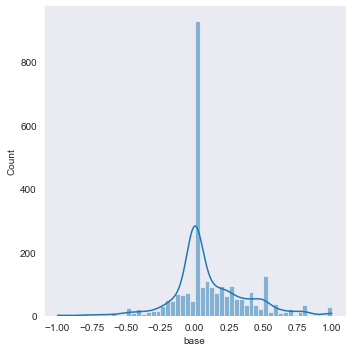

In [7]:
sns.set_style('dark')
g = sns.displot(ind_mar_25_2020_df.base,kde=True)

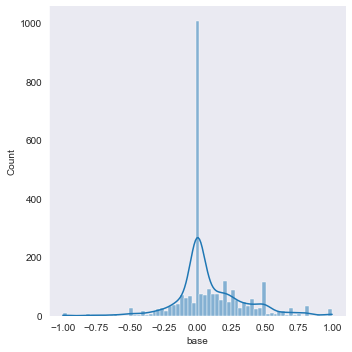

In [8]:
sns.set_style('dark')
g = sns.displot(ind_mar_27_2020_df.base,kde=True)

We can see that about half of the datapoints have the score of **0.0** or Neutral Sentiment. That is good to take as the baseline for our analysis, but we will try to improve this with a more fine-grained approach by applying recent breakthroughs in the domain of Sentiment Analysis.

# 3. Data Preprocessing

In [9]:
#before preprocessing
ind_mar_20_2020_df.head()

,id,base,place,text
0,1240727929065111553,0.000000,"Jaipur, India",Insitute of Economics and Management studies: Corona virus Infection Impact ON INDIAN ECONOMY. https://t.co/mYxKb4MUKL
1,1240728214319714304,0.172222,"Bengaluru South, India",Amidst the corona scare - let’s not forget to do what we love. Let’s work on all goals we had for the days our offices would shut down. #coffeebells #corona #staysafe #selfquarantine #ipad #ipadart #sketch #painting https://t.co/ekTpWHM67r
2,1240728335795159040,-0.078125,"Bengaluru South, India","@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy"
3,1240728972335300608,0.000000,"Bhopal, India",@BDUTT What about #Favipiravir #Remdesivir #Lopinavir &amp; #Ritonavir ???\n\nhttps://t.co/Cw2Y31mOnY
4,1240729038584455170,0.283333,"Ghaziabad, India","@ultrascanhumint anchored Marco Polo is half-busy.\nIntelligent advisors with half boiled brains are crimi**lly exploiting Cameras[ since World tour is not materializing ], a Flag, in corona issue for ego promotion, a constant issue\n\nseminars, SARC videoconferencing prominently displayed 'World'"


## Building the Text Preprocessing pipelines for multiple libraries

In [10]:
#punctuations, stopwords, tokenizer, and lemmatizer
english_punctuations = string.punctuation
eng_stopwords = stopwords.words('english')
covid_stopwords = ['’', 'corona', 'coronavirus', 'covid', 'covid19', 'covid-19', 'sarscov2', 'sars cov2', 'sars cov 2', 'covid_19', 'ncov', 
                    'ncov2019', '2019-ncov', 'pandemic', '2019ncov', 'quarantine', 'flatten the curve', 'flattening the curve', 'hand sanitizer', 
                    'lockdown', 'social distancing', 'work from home', 'working from home', 'ppe', 'n95', 'covidiots', 'herd immunity', 
                    'pneumonia', 'chinese virus', 'wuhan virus', 'kung flu', 'wearamask', 'wear a mask', 'vaccine', 'vaccines', 'corona vaccine', 
                    'corona vaccines', 'face shield', 'face shields', 'health worker', 'health workers', 'wash ur hands', 'wash your hands', 
                    'self isolating', 'lungs', 'fever', 'cough', 'virus', 'flu', 'wuhan', 'flattenthecurve', 'handsanitizer', 'socialdistancing', 
                    'workfromhome', 'workingfromhome', 'herdimmunity', 'chinesevirus', 'wuhanvirus', 'kungflu', 'coronavaccine', 'coronavaccines'
                    'faceshield', 'faceshields', 'healthworker', 'healthworkers', 'washurhands', 'washyourhands', 'selfisolating']
tokenizer = RegexpTokenizer(r'[\w]+')
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_for_textblob(tweet):
    cleaned_text = tweet
    cleaned_text = re.sub(r'RT[\s]+', '', cleaned_text) #removing RT symbol for retweets
    cleaned_text = cleaned_text.lower() #lowercasing all texts
    cleaned_text = re.sub(r"’", "'", cleaned_text) #correcting the apostrophe symbol
    cleaned_text = re.sub(r'#', '', cleaned_text) #removing the '#' symbol
    cleaned_text = re.sub(r'@[a-z0-9]+', '', cleaned_text) #removing all @mentions
    cleaned_text = re.sub(r'((www.[^s]+)|(https?://[^s]+))', ' ', cleaned_text) #removing URL links
    cleaned_text = re.sub(r'[0-9]+', '', cleaned_text) #removing any numeric characters
    cleaned_text = re.sub(r'(.)\1+', r'\1\1', cleaned_text) #removing >1 repeating characters
    cleaned_text = re.sub(' +', ' ', cleaned_text) #removing multiple whitespaces
    
    cleaned_text = emoji.demojize(cleaned_text) #converting emojis to their expressions
    cleaned_text = cleaned_text.replace(":", " ")
    cleaned_text = ' '.join(cleaned_text.split())
    
    cleaned_text = " ".join(word for word in cleaned_text.split() if word not in eng_stopwords) #remove english stopwords
    cleaned_text = " ".join(word for word in cleaned_text.split() if word not in covid_stopwords) #removing custom covid stopwords
    cleaned_text = "".join(char for char in cleaned_text if char not in english_punctuations) #removing english punctuations
    
    #cleaned_text = tokenizer.tokenize(cleaned_text) #tokenizes the words | TextBlob takes strings, not tokens
    cleaned_text = " ".join([lemmatizer.lemmatize(word) for word in cleaned_text.split()]) #lematize without tokenizing
    #cleaned_text = [lemmatizer.lemmatize(word) for word in cleaned_text] #lematize after tokenizing
    return cleaned_text

In [12]:
def preprocess_for_vader(tweet):
    cleaned_text = tweet
    cleaned_text = re.sub(r'RT @[\w]*:', '', cleaned_text) #removing RT handles
    cleaned_text = re.sub(r'@[\w]*', '', cleaned_text) #removing all @mentions
    cleaned_text = re.sub(r'((www.[^s]+)|(https?://[^s]+))', ' ', cleaned_text) #removing URL links
    cleaned_text = np.core.defchararray.replace(cleaned_text, "[^a-zA-Z#]", " ") #removing special characters, numbers and punctuations except #
    
    return cleaned_text

In [13]:
#testing the textblob preprocessing function
test_word = '@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😁 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy'
print(preprocess_for_textblob(test_word))

italy report death highest singleday death toll country italy total case hit beamingfacewithsmilingeyes sadbutrelievedface anxiousfacewithsweat anxiousfacewithsweat alarming indeed heart go people italy mapleleaf greenheart coronavirusoutbreak coronavirusupdates europe italy


In [14]:
test_word = '@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😁 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy'
print(preprocess_for_vader(test_word))

  Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😁 😥😰😰😰
Alarming indeed...!! Heart goes out to the people of Italy. 🍁💚
#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy


## Preprocessing the available Datasets

In [15]:
#Preprocessing for TextBlob
ind_mar_20_2020_df["blob_text"] = ind_mar_20_2020_df["text"].apply(lambda x: preprocess_for_textblob(x))
ind_mar_20_2020_df.head(5)

,id,base,place,text,blob_text
0,1240727929065111553,0.000000,"Jaipur, India",Insitute of Economics and Management studies: Corona virus Infection Impact ON INDIAN ECONOMY. https://t.co/mYxKb4MUKL,insitute economics management study infection impact indian economy
1,1240728214319714304,0.172222,"Bengaluru South, India",Amidst the corona scare - let’s not forget to do what we love. Let’s work on all goals we had for the days our offices would shut down. #coffeebells #corona #staysafe #selfquarantine #ipad #ipadart #sketch #painting https://t.co/ekTpWHM67r,amidst scare let forget love let work goal day office would shut down coffeebells staysafe selfquarantine ipad ipadart sketch painting
2,1240728335795159040,-0.078125,"Bengaluru South, India","@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy",italy report death highest singleday death toll country italy total case hit sadbutrelievedface anxiousfacewithsweat anxiousfacewithsweat alarming indeed heart go people italy mapleleaf greenheart coronavirusoutbreak coronavirusupdates europe italy
3,1240728972335300608,0.000000,"Bhopal, India",@BDUTT What about #Favipiravir #Remdesivir #Lopinavir &amp; #Ritonavir ???\n\nhttps://t.co/Cw2Y31mOnY,favipiravir remdesivir lopinavir amp ritonavir
4,1240729038584455170,0.283333,"Ghaziabad, India","@ultrascanhumint anchored Marco Polo is half-busy.\nIntelligent advisors with half boiled brains are crimi**lly exploiting Cameras[ since World tour is not materializing ], a Flag, in corona issue for ego promotion, a constant issue\n\nseminars, SARC videoconferencing prominently displayed 'World'",anchored marco polo halfbusy intelligent advisor half boiled brain crimilly exploiting camera since world tour materializing flag issue ego promotion constant issue seminar sarc videoconferencing prominently displayed world


In [16]:
ind_mar_20_2020_df["vader_text"] = ind_mar_20_2020_df["text"].apply(lambda x: preprocess_for_vader(x))
ind_mar_20_2020_df.head(5)

,id,base,place,text,blob_text,vader_text
0,1240727929065111553,0.000000,"Jaipur, India",Insitute of Economics and Management studies: Corona virus Infection Impact ON INDIAN ECONOMY. https://t.co/mYxKb4MUKL,insitute economics management study infection impact indian economy,Insitute of Economics and Management studies: Corona virus Infection Impact ON INDIAN ECONOMY.
1,1240728214319714304,0.172222,"Bengaluru South, India",Amidst the corona scare - let’s not forget to do what we love. Let’s work on all goals we had for the days our offices would shut down. #coffeebells #corona #staysafe #selfquarantine #ipad #ipadart #sketch #painting https://t.co/ekTpWHM67r,amidst scare let forget love let work goal day office would shut down coffeebells staysafe selfquarantine ipad ipadart sketch painting,Amidst the corona scare - let’s not forget to do what we love. Let’s work on all goals we had for the days our offices would shut down. #coffeebells #corona #staysafe #selfquarantine #ipad #ipadart #sketch #painting
2,1240728335795159040,-0.078125,"Bengaluru South, India","@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy",italy report death highest singleday death toll country italy total case hit sadbutrelievedface anxiousfacewithsweat anxiousfacewithsweat alarming indeed heart go people italy mapleleaf greenheart coronavirusoutbreak coronavirusupdates europe italy,"Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy"
3,1240728972335300608,0.000000,"Bhopal, India",@BDUTT What about #Favipiravir #Remdesivir #Lopinavir &amp; #Ritonavir ???\n\nhttps://t.co/Cw2Y31mOnY,favipiravir remdesivir lopinavir amp ritonavir,What about #Favipiravir #Remdesivir #Lopinavir &amp; #Ritonavir ???\n\n
4,1240729038584455170,0.283333,"Ghaziabad, India","@ultrascanhumint anchored Marco Polo is half-busy.\nIntelligent advisors with half boiled brains are crimi**lly exploiting Cameras[ since World tour is not materializing ], a Flag, in corona issue for ego promotion, a constant issue\n\nseminars, SARC videoconferencing prominently displayed 'World'",anchored marco polo halfbusy intelligent advisor half boiled brain crimilly exploiting camera since world tour materializing flag issue ego promotion constant issue seminar sarc videoconferencing prominently displayed world,"anchored Marco Polo is half-busy.\nIntelligent advisors with half boiled brains are crimi**lly exploiting Cameras[ since World tour is not materializing ], a Flag, in corona issue for ego promotion, a constant issue\n\nseminars, SARC videoconferencing prominently displayed 'World'"


# 4. Scoring the Sentiments

## TextBlob

In [17]:
ind_mar_20_2020_df["blob_score"] = ind_mar_20_2020_df["blob_text"].apply(lambda x: TextBlob(x).sentiment.polarity)
ind_mar_20_2020_df.head(5)

,id,base,place,text,blob_text,vader_text,blob_score
0,1240727929065111553,0.000000,"Jaipur, India",Insitute of Economics and Management studies: Corona virus Infection Impact ON INDIAN ECONOMY. https://t.co/mYxKb4MUKL,insitute economics management study infection impact indian economy,Insitute of Economics and Management studies: Corona virus Infection Impact ON INDIAN ECONOMY.,0.000000
1,1240728214319714304,0.172222,"Bengaluru South, India",Amidst the corona scare - let’s not forget to do what we love. Let’s work on all goals we had for the days our offices would shut down. #coffeebells #corona #staysafe #selfquarantine #ipad #ipadart #sketch #painting https://t.co/ekTpWHM67r,amidst scare let forget love let work goal day office would shut down coffeebells staysafe selfquarantine ipad ipadart sketch painting,Amidst the corona scare - let’s not forget to do what we love. Let’s work on all goals we had for the days our offices would shut down. #coffeebells #corona #staysafe #selfquarantine #ipad #ipadart #sketch #painting,0.172222
2,1240728335795159040,-0.078125,"Bengaluru South, India","@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy",italy report death highest singleday death toll country italy total case hit sadbutrelievedface anxiousfacewithsweat anxiousfacewithsweat alarming indeed heart go people italy mapleleaf greenheart coronavirusoutbreak coronavirusupdates europe italy,"Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy",-0.050000
3,1240728972335300608,0.000000,"Bhopal, India",@BDUTT What about #Favipiravir #Remdesivir #Lopinavir &amp; #Ritonavir ???\n\nhttps://t.co/Cw2Y31mOnY,favipiravir remdesivir lopinavir amp ritonavir,What about #Favipiravir #Remdesivir #Lopinavir &amp; #Ritonavir ???\n\n,0.000000
4,1240729038584455170,0.283333,"Ghaziabad, India","@ultrascanhumint anchored Marco Polo is half-busy.\nIntelligent advisors with half boiled brains are crimi**lly exploiting Cameras[ since World tour is not materializing ], a Flag, in corona issue for ego promotion, a constant issue\n\nseminars, SARC videoconferencing prominently displayed 'World'",anchored marco polo halfbusy intelligent advisor half boiled brain crimilly exploiting camera since world tour materializing flag issue ego promotion constant issue seminar sarc videoconferencing prominently displayed world,"anchored Marco Polo is half-busy.\nIntelligent advisors with half boiled brains are crimi**lly exploiting Cameras[ since World tour is not materializing ], a Flag, in corona issue for ego promotion, a constant issue\n\nseminars, SARC videoconferencing prominently displayed 'World'",0.283333


## VADER

In [18]:
#initializing and testing
test_word = '@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😁 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy'
analyser = SentimentIntensityAnalyzer()
analyser.polarity_scores(test_word)

{'neg': 0.165, 'neu': 0.624, 'pos': 0.211, 'compound': 0.8331}

In [19]:
ind_mar_20_2020_df["vader_score"] = ind_mar_20_2020_df["vader_text"].apply(lambda x: analyser.polarity_scores(x)["compound"])
ind_mar_20_2020_df.tail(5)

,id,base,place,text,blob_text,vader_text,blob_score,vader_score
2358,1241155268144029696,0.500000,"Vishakhapatnam, India","@pmo @narendramodi @DPE_GoI @heindustry @SteelMinIndia @SAILsteel How to stop Corona virus, can't be with circular of DPE &amp; DoPT, Reducing the contacts between humans is the key.There are many organisations who can be asked to work from home irrespective of executive/non exec. https://t.co/jUWFohJLmR",goi stop virus cant circular dpe amp dopt reducing contact human keythere many organisation asked work home irrespective executivenon exec,"How to stop Corona virus, can't be with circular of DPE &amp; DoPT, Reducing the contacts between humans is the key.There are many organisations who can be asked to work from home irrespective of executive/non exec.",0.250000,-0.2960
2359,1241155407231344640,0.000000,"Haora, India",#IndiaFightsCorona\nSankalp and Sanyam needed to combat Corona\nvia NaMo App https://t.co/s6fIzZpN8s,indiafightscorona sankalp sanyam needed combat via namo app sfizzpns,#IndiaFightsCorona\nSankalp and Sanyam needed to combat Corona\nvia NaMo App s6fIzZpN8s,0.000000,-0.3400
2360,1241155465465098240,0.500000,"Vishakhapatnam, India","@PMOIndia @RINL_VSP @narendramodi @pmo @narendramodi @DPE_GoI @heindustry How to stop Corona virus, can't be with circular of DPE &amp; DoPT, Reducing the contacts between humans is the key.There are many organisations who can be asked to work from home irrespective of executive/non exec. https://t.co/QsDFcacuz7",vsp goi stop virus cant circular dpe amp dopt reducing contact human keythere many organisation asked work home irrespective executivenon exec sdfcacuz,"How to stop Corona virus, can't be with circular of DPE &amp; DoPT, Reducing the contacts between humans is the key.There are many organisations who can be asked to work from home irrespective of executive/non exec. sDFcacuz7",0.250000,-0.2960
2361,1241155681303945216,-0.125000,"Faridabad, India","U act &amp; write as u r law unto yourself , like all other who r working for the country , Parliamentarians need to work &amp; earn , they have to lead by example but mayopic person like u won’t understand that https://t.co/WVXMQdSduq",u act amp write u r law unto like r working country parliamentarian need work amp earn lead example mayopic person like u understand sduq,"U act &amp; write as u r law unto yourself , like all other who r working for the country , Parliamentarians need to work &amp; earn , they have to lead by example but mayopic person like u won’t understand that",0.000000,0.6124
2362,1241156162885582849,0.105952,"Faridabad, India",U r right this lady is nuts &amp; crazy thinks she is the Big B of media infact she is Chirkut who only sensationalises need to remain in lime light &amp; keeps tweeting controversial statements https://t.co/O8AK2u5K3E,u r right lady nut amp crazy think big b medium infact chirkut sensationalises need remain lime light amp keep tweeting controversial statement,U r right this lady is nuts &amp; crazy thinks she is the Big B of media infact she is Chirkut who only sensationalises need to remain in lime light &amp; keeps tweeting controversial statements,0.127143,-0.6705


## Visualizing Sentiment Scores from TextBlob and VADER

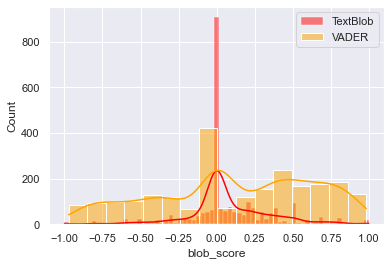

In [20]:
sns.set(style="darkgrid")
sns.histplot(data=ind_mar_20_2020_df, x="blob_score", color="red", label="TextBlob", kde=True)
sns.histplot(data=ind_mar_20_2020_df, x="vader_score", color="orange", label="VADER", kde=True)

plt.legend() 
plt.show()


## Experimenting and training on HuggingFace transformers for fetching user's tweet and show score demo

In [21]:
!pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio===0.9.1 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers

Looking in links: https://download.pytorch.org/whl/torch_stable.html


In [22]:
#initializing our roBERTa-base Twitter model
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

C:\Users\KIIT\miniconda3\lib\site-packages\transformers\configuration_utils.py:337: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [23]:
test_word = '@NorbertElekes @SamKhan999 Italy reports 475 coronavirus deaths, the highest single-day death toll for any country. Italy’s total Corona virus cases hit 41,000. 😁 😥😰😰😰\nAlarming indeed...!! Heart goes out to the people of Italy. 🍁💚\n#CoronavirusOutbreak #CoronaVirusUpdates #coronavirus #Europe #Italy'

In [24]:
#we will use the roberta sentiment to show % of pos, neu or neg of the tweet entered by the user in the live dashboard
inputs = tokenizer(test_word, return_tensors="pt")
outputs = model(**inputs)
scores = outputs[0][0].detach().numpy()
scores = softmax(scores)
scores

array([0.8601887 , 0.12367324, 0.01613794], dtype=float32)

In [25]:
#we will use the VADER score to show the overall sentiment and the frequency proportion for each sentiment on the map
analyser = SentimentIntensityAnalyzer()
analyser.polarity_scores(test_word)

{'neg': 0.165, 'neu': 0.624, 'pos': 0.211, 'compound': 0.8331}

# 5. Building Sentiment Pipeline with VADER

In [3]:
def getSentiment(ind_csvPath, score_csvPath):
    # 1.reading DF with Indian data
    ind_df = pd.read_csv(ind_csvPath)
    
    # 2.preprocessing the tweet text
    def preprocess_for_vader(tweet):
        cleaned_text = tweet
        cleaned_text = re.sub(r'RT @[\w]*:', '', cleaned_text) #removing RT handles
        cleaned_text = re.sub(r'@[\w]*', '', cleaned_text) #removing all @mentions
        cleaned_text = re.sub(r'((www.[^s]+)|(https?://[^s]+))', ' ', cleaned_text) #removing URL links
        cleaned_text = np.core.defchararray.replace(cleaned_text, "[^a-zA-Z#]", " ") #removing special characters, numbers and punctuations except #
        return cleaned_text
    
    ind_df["vader_text"] = ind_df["text"].apply(lambda x: preprocess_for_vader(x))
    
    # 3.sentiment scoring with VADER
    analyser = SentimentIntensityAnalyzer()
    ind_df["vader_score"] = ind_df["vader_text"].apply(lambda x: analyser.polarity_scores(x)["compound"])
    
    # 4.exporting DF with scores to path given
    ind_df.to_csv(score_csvPath, index=False)

In [5]:
#getting the CSV with Sentiment Scores for March 27, 2020
indianCSV_path = "C:\Data Science\Jupyter_Workspace\Twitter_Sentiment\Data\March27_20\Hydrated\mar27_ind_df.csv"
scoresCSV_path = "C:\Data Science\Jupyter_Workspace\Twitter_Sentiment\Data\March27_20\Hydrated\mar27_score_df.csv"
getSentiment(indianCSV_path, scoresCSV_path)

In [4]:
#March 25, 2020
indianCSV_path = "C:\Data Science\Jupyter_Workspace\Twitter_Sentiment\Data\\March25_20\Hydrated\\mar25_ind_df.csv"
scoresCSV_path = "C:\Data Science\Jupyter_Workspace\Twitter_Sentiment\Data\\March25_20\Hydrated\\mar25_score_df.csv"
getSentiment(indianCSV_path, scoresCSV_path)